In [1]:
import numpy as np
import tensorflow as tf
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError
from datetime import datetime

# He et al. initialization from https://arxiv.org/abs/1502.01852
he_init = tf.contrib.layers.variance_scaling_initializer()

# This class inherits from Sklearn's BaseEstimator and ClassifierMixin 
class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, 
                 optimizer_class=tf.train.AdamOptimizer, 
                 learning_rate=0.01, batch_size=64, 
                 activation=tf.nn.elu, initializer=he_init, 
                 batch_norm_momentum=None, dropout_rate=None, 
                 max_checks_without_progress=20, show_progress=10, 
                 tensorboard_logdir=None, random_state=None):

        # Initialize the class with sensible default hyperparameters
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.max_checks_without_progress = max_checks_without_progress
        self.show_progress = show_progress
        self.random_state = random_state
        self.tensorboard_logdir = tensorboard_logdir
        self._session = None # Instance variables preceded by _ are private members

    def _dnn(self, inputs):
        '''This method builds the hidden layers and 
        Provides for implementation of batch normalization and dropout'''

        for layer in range(self.n_hidden_layers):

            # Apply dropout if specified
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, rate=self.dropout_rate, training=self._training)
            # Create the hidden layer
            inputs = tf.layers.dense(inputs, self.n_neurons, 
                                     activation=self.activation, 
                                     kernel_initializer=self.initializer, 
                                     name = "hidden{}".format(layer+1))

            # Apply batch normalization if specified
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs,momentum=self.batch_norm_momentum,
                                                       training=self._training)

            # Apply activation function
            inputs = self.activation(inputs, name="hidden{}_out".format(layer+1))
        return inputs

    def _construct_graph(self, n_inputs, n_outputs):
        '''This method builds the complete Tensorflow computation graph
        n_inputs: number of features 
        n_outputs: number of classes
        '''

        if self.random_state:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)
 
        # Placeholders for training data, labels are class exclusive integers
        X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
        y = tf.placeholder(tf.int32, shape=[None], name="y")
        
        # Create a training placeholder 
        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=[], name="training")
        else:
            self._training = None

        # Output after hidden layers 
        pre_output = self._dnn(X)
        
        # Outputs from output layer
        logits = tf.layers.dense(pre_output, n_outputs, kernel_initializer=he_init, name="logits")
        probabilities = tf.nn.softmax(logits, name="probabilities")
        
        ''' Cost function is cross entropy and loss is average cross entropy. Sparse softmax must be used because shape of logits is [None, n_classes] and shape of labels is [None]'''
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        '''Optimizer and training operation. The control dependency is necessary for implementing batch normalization. The training operation must be dependent on the batch normalization.'''

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            training_op = optimizer.minimize(loss)

        # Metrics for evaluation
        correct = tf.nn.in_top_k(logits, y, 1)    
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32),name="accuracy")

        # Initializer and saver 
        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        if self.tensorboard_logdir:
            now = datetime.utcnow().strftime('%Y%m%d-%H%M%S')
            tb_logdir = self.tensorboard_logdir + "/run-{}".format(now)
            cost_summary = tf.summary.scalar("validation_loss", loss)
            acc_summary = tf.summary.scalar("validation_accuracy", accuracy)
            merged_summary = tf.summary.merge_all()
            file_writer = tf.summary.FileWriter(tb_logdir, tf.get_default_graph())

            self._merged_summary = merged_summary
            self._file_writer = file_writer

        self._X, self._y = X, y
        self._logits = logits
        self._probabilities = probabilities
        self._loss = loss
        self._training_op = training_op
        self._accuracy = accuracy
        self._init, self._saver = init, saver

        
    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_parameters(self):
        # Retrieves the value of all the variables in the network 
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in 
                zip(gvars, self._session.run(gvars))}

    def _restore_model_parameters(self, model_params):
        # Restores the value of all variables using tf assign operations
        # First retrieve the list of all the graph variables
        gvar_names = list(model_params.keys())

        # Then retrieve all the assignment operations in the graph
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name +  "/Assign") for gvar_name in gvar_names}

        # Fetch the initialization values of the assignment operations
        '''graph.get_operation_by_name(operation).inputs returns the input to the given operation; because these are all assignment operations, the second argument to inputs is the value assigned to the variable'''
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op 			  in assign_ops.items()}
        # Create a dictionary mapping initial values to values after training
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        # Assign the trained value to all the variables in the graph
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        # Method to train the model. Implements early stopping if validation data is provided 

        self.close_session()
        n_inputs = X.shape[1] # Number of features

        # If labels are provided in one_hot form, convert to integer class labels
        y = np.array(y)
        y_valid = np.array(y_valid)

        if len(y.shape) == 2:
            y = np.argmax(y, axis=1)
 
        if len(y_valid.shape) == 2:
            y_valid = np.argmax(y_valid, axis=1)

        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_) # Number of classes

        # Tensorflow expects labels from 0 to n_classes - 1. 
        self.class_to_index_ = {label: index for index, label in enumerate(self.classes_)}
        labels = [self.class_to_index_[label] for label in y]
        y = np.array(labels, dtype=np.int32)

        self._graph = tf.Graph()

        # Build the computation graph with self as default graph
        with self._graph.as_default():
            self._construct_graph(n_inputs, n_outputs)

        # Early stopping parameters
        checks_without_progress = 0 
        best_loss = np.float("inf")
        best_parameters = None
        
        self._session = tf.Session(graph=self._graph)

        with self._session.as_default() as sess:
            # Initialize all variables
            self._init.run()
            num_instances = X.shape[0] # Total number of training instances
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(num_instances)
                for rnd_indices in np.array_split(rnd_idx, num_instances // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    train_acc, _ = sess.run([self._accuracy,self._training_op], feed_dict)

                # Early stopping implementation
                if X_valid is not None and y_valid is not None:
                    feed_dict_valid = {self._X: X_valid, self._y: y_valid}

                    # Write summary for tensorboard
                    if self.tensorboard_logdir:
                        val_acc, val_loss, summary = sess.run([self._accuracy, self._loss, self._merged_summary], feed_dict=feed_dict_valid)

                        self._file_writer.add_summary(summary, epoch)

                    else:
                        val_acc, val_loss = sess.run([self._accuracy, self._loss], feed_dict=feed_dict_valid)

                    # Show training progress every show_progress epochs
                    if self.show_progress:
                        if epoch % self.show_progress == 0:
                            print("Epoch: {} Current training accuracy: {:.4f} Validation Accuracy: {:.4f} Validation Loss {:.6f}".format(
                                epoch+1, train_acc, val_acc, val_loss))

                    # Check to see if model is improving 
                    if val_loss < best_loss:
                        best_loss = val_loss
                        checks_without_progress = 0
                        best_parameters = self._get_model_parameters()
                    else:
                        checks_without_progress += 1

                    if checks_without_progress > self.max_checks_without_progress:
                        print("Stopping Early! Loss has not improved in {} epochs".format(self.max_checks_without_progress))
                        break
   
                # No validation set provided
                else:
                    if self.show_progress:
                        if epoch % self.show_progress == 0:
                            print("Epoch: {} Current training accuracy: {:.4f}".format(epoch+1, train_acc))

            # In the case of early stopping, restore the best weight values
            if best_parameters:
                self._restore_model_parameters(best_parameters)
                return self

    def predict_probabilities(self, X):
        # Predict the probabilities of each class 
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._probabilities.eval(feed_dict={self._X: X})

    def predict(self, X):
        # Predict the classes themselves and return with shape=(None,)
        class_indices = np.argmax(self.predict_probabilities(X), axis=1)
        predictions = np.array([[self.classes_[class_index]] for class_index in class_indices], dtype=np.int32)
        return np.reshape(predictions, (-1,))

    def save(self, path):
        # Save the model to provided path
        self._saver.save(self._session, path)

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data")

X_train = mnist.train.images
y_train = mnist.train.labels

X_validation = mnist.validation.images
y_validation = mnist.validation.labels

X_test = mnist.test.images
y_test = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
dnn = DNNClassifier(tensorboard_logdir="tensorboard_stats", random_state=42)
dnn.fit(X_train, y_train, 100, X_validation, y_validation)

Epoch: 1 Current training accuracy: 0.9375 Validation Accuracy: 0.9490 Validation Loss 0.197036
Epoch: 11 Current training accuracy: 0.9219 Validation Accuracy: 0.9626 Validation Loss 0.217349
Epoch: 21 Current training accuracy: 0.9531 Validation Accuracy: 0.9412 Validation Loss 0.312047
Stopping Early! Loss has not improved in 20 epochs


DNNClassifier(activation=<function elu at 0x11861a5f0>,
       batch_norm_momentum=None, batch_size=64, dropout_rate=None,
       initializer=<function _initializer at 0xf20bc9140>,
       learning_rate=0.01, max_checks_without_progress=20,
       n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42, show_progress=10,
       tensorboard_logdir='tensorboard_stats')

In [4]:
from sklearn.metrics import accuracy_score

y_pred = dnn.predict(X_test)
print("Accuracy on the test set: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

Accuracy on the test set: 95.85%


In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

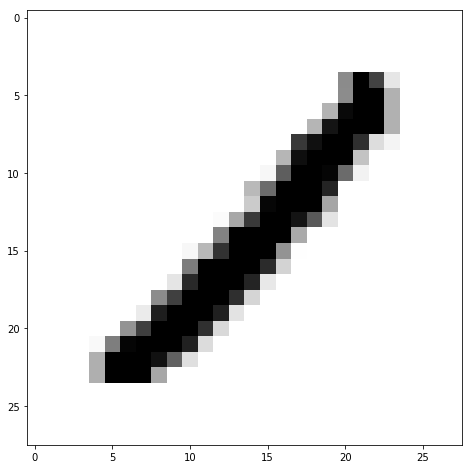

0 Confidence: 0.00%
1 Confidence: 100.00%
2 Confidence: 0.00%
3 Confidence: 0.00%
4 Confidence: 0.00%
5 Confidence: 0.00%
6 Confidence: 0.00%
7 Confidence: 0.00%
8 Confidence: 0.00%
9 Confidence: 0.00%


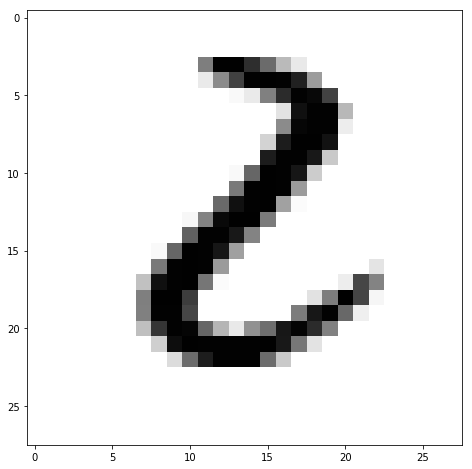

0 Confidence: 0.01%
1 Confidence: 0.16%
2 Confidence: 98.81%
3 Confidence: 0.11%
4 Confidence: 0.05%
5 Confidence: 0.00%
6 Confidence: 0.00%
7 Confidence: 0.01%
8 Confidence: 0.84%
9 Confidence: 0.00%


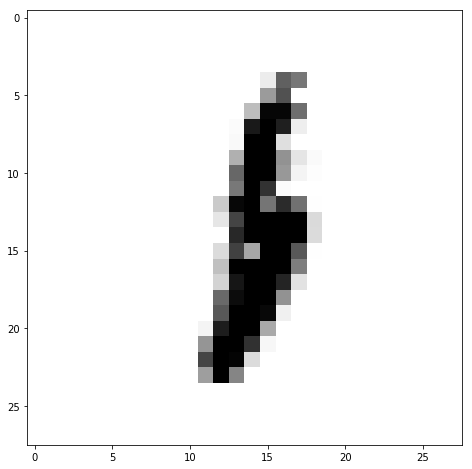

0 Confidence: 0.05%
1 Confidence: 90.36%
2 Confidence: 1.56%
3 Confidence: 0.22%
4 Confidence: 1.02%
5 Confidence: 0.15%
6 Confidence: 2.15%
7 Confidence: 0.61%
8 Confidence: 3.65%
9 Confidence: 0.24%


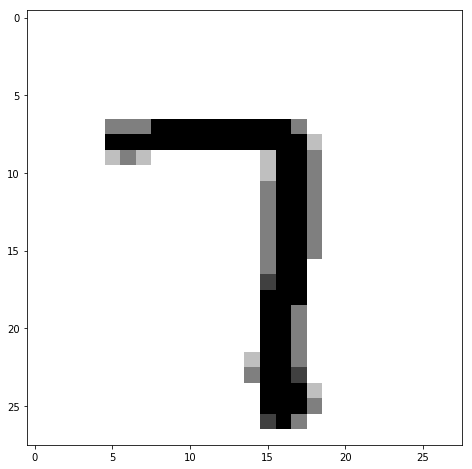

0 Confidence: 0.00%
1 Confidence: 0.00%
2 Confidence: 0.02%
3 Confidence: 0.00%
4 Confidence: 0.00%
5 Confidence: 0.00%
6 Confidence: 0.00%
7 Confidence: 99.97%
8 Confidence: 0.00%
9 Confidence: 0.00%


In [6]:
example_indices = np.random.randint(len(X_test), size=4)

for i, image_index in enumerate(example_indices):
    probabilities = dnn.predict_probabilities(X_test[image_index].reshape(-1, 784))
    plt.figure(figsize=(8,8))
    plt.imshow(X_test[image_index].reshape(28,28), cmap="binary")
    plt.show()
    for label, probability in zip(dnn.classes_, probabilities[0]):
        print("{} Confidence: {:.2f}%".format(label, probability*100))

### Use Randomized Search to find the best hyperparameters

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [14]:
import tensorflow as tf

dnn = DNNClassifier(show_progress=None, random_state=42)

parameter_distributions = {
    'n_hidden_layers': [4, 5],
    'n_neurons': [50, 100],
    'dropout_rate': [None, 0.5]
}

random_search = RandomizedSearchCV(dnn, parameter_distributions, n_iter=5, scoring='accuracy', verbose=2)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_hidden_layers=5, n_neurons=50, dropout_rate=0.5 ...............
[CV]  n_hidden_layers=5, n_neurons=50, dropout_rate=0.5, total= 3.0min
[CV] n_hidden_layers=5, n_neurons=50, dropout_rate=0.5 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min remaining:    0.0s


[CV]  n_hidden_layers=5, n_neurons=50, dropout_rate=0.5, total= 3.0min
[CV] n_hidden_layers=5, n_neurons=50, dropout_rate=0.5 ...............
[CV]  n_hidden_layers=5, n_neurons=50, dropout_rate=0.5, total= 3.0min
[CV] n_hidden_layers=4, n_neurons=50, dropout_rate=0.5 ...............
[CV]  n_hidden_layers=4, n_neurons=50, dropout_rate=0.5, total= 2.7min
[CV] n_hidden_layers=4, n_neurons=50, dropout_rate=0.5 ...............
[CV]  n_hidden_layers=4, n_neurons=50, dropout_rate=0.5, total= 2.7min
[CV] n_hidden_layers=4, n_neurons=50, dropout_rate=0.5 ...............
[CV]  n_hidden_layers=4, n_neurons=50, dropout_rate=0.5, total= 2.6min
[CV] n_hidden_layers=5, n_neurons=100, dropout_rate=0.5 ..............
[CV]  n_hidden_layers=5, n_neurons=100, dropout_rate=0.5, total= 4.0min
[CV] n_hidden_layers=5, n_neurons=100, dropout_rate=0.5 ..............
[CV]  n_hidden_layers=5, n_neurons=100, dropout_rate=0.5, total= 3.9min
[CV] n_hidden_layers=5, n_neurons=100, dropout_rate=0.5 ..............
[CV]

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 42.9min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x11861a5f0>,
       batch_norm_momentum=None, batch_size=64, dropout_rate=None,
       initializer=<function _initializer at 0xf20bc9140>,
       learning_rate=0.01, max_checks_without_progress=20,
       n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42, show_progress=None, tensorboard_logdir=None),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'n_hidden_layers': [4, 5], 'n_neurons': [50, 100], 'dropout_rate': [None, 0.5]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=2)

In [15]:
random_search.best_params_

{'dropout_rate': None, 'n_hidden_layers': 4, 'n_neurons': 100}

In [16]:
best_mnist_dnn = random_search.best_estimator_
mnist_predictions = best_mnist_dnn.predict(X_test)

print("Accuracy on test set: {:.2f}%".format(accuracy_score(y_test, mnist_predictions) * 100))

Accuracy on test set: 88.51%


In [17]:
random_search.best_estimator_.save("models/mnist_random_best_model")